# Visual Odometry - KITTI Odometry Dataset

This notebook uses OpenCV to apply stereo depth estimation and multi-view geometry to attempt to track vehicle position through a sequence of the KITTI odometry dataset. A dataset handler class is provided to easily interact with the provided data and sensor calibration information. Useful functions are also provided to perform this basic example of visual odometry using the opencv-python package. 
While exploring this dataset, this notebook will review fundamental computer vision principles required to perform the task of stereo depth estimation and visual odometry, and demonstrate the implementation of those principles using numpy and OpenCV in Python.

These topics will include:

- The pinhole camera model
- Intrinsic and extrinsic camera parameters and matrices
- Projection matrices
- Rectified projection matrices
- Projective geometry
- 3D tranformations
- Disparity and depth estimation from stereo
- Image Feature detection/description/matching
- Pose estimation from Perspective n Point (PnP) algorithm using RANSAC

In [122]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import cv2

In [123]:
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('OpenCV', cv2.__version__)

NumPy 2.2.6
Pandas 2.2.3
Matplotlib 3.10.3
OpenCV 4.12.0


## Data Exploration

In [124]:
#exploring dataset contents
dataset_path ="./dataset"
sequence_path = os.path.join(dataset_path, "sequences", "00") #sequence: 00
gt_path = os.path.join(dataset_path, "poses", "00")

print("contents of the dataset directory: ",os.listdir(dataset_path))
print("contents of the ground truth directory", os.listdir(gt_path))
print("contents of the sequence: 00 directory", os.listdir(sequence_path))


contents of the dataset directory:  ['poses', 'sequences']
contents of the ground truth directory ['00.txt']
contents of the sequence: 00 directory ['calib.txt', 'image_0', 'image_1', 'times.txt', 'velodyne']


![SNOWFALL](kitti_schematic.png)

In [125]:
#exploring ground truth data
gt_data_path = os.path.join(gt_path, "00.txt")
gt_poses = pd.read_csv(gt_data_path, delimiter=' ', header=None)
print('Shape of position dataframe:', gt_poses.shape)
gt_poses.head()

Shape of position dataframe: (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [126]:
print('First ground truth pose:')
first_pose = np.asarray(gt_poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First ground truth pose:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

In [127]:
#loading csv data to numpy array
num_frames = len(gt_poses)
gt = np.zeros((num_frames, 3, 4)) 

for i in range(num_frames):
    gt[i,:,:] = np.array(gt_poses.iloc[i]).reshape((3, 4))

In [128]:
#inspecting the first few vehicle poses
#extracting only the translation part to draw the trajectory probably
# the poses 00.txt is translation and rotation only
camera_origin_HC = np.array([0,0,0,1])
for i in range(8):
    print(f"Pose {i}",gt[i].dot(camera_origin_HC).round(2))

Pose 0 [ 0.  0. -0.]
Pose 1 [-0.05 -0.03  0.86]
Pose 2 [-0.09 -0.06  1.72]
Pose 3 [-0.14 -0.09  2.57]
Pose 4 [-0.19 -0.11  3.43]
Pose 5 [-0.23 -0.14  4.29]
Pose 6 [-0.28 -0.17  5.15]
Pose 7 [-0.33 -0.2   6.01]


In [129]:
gt[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16]])

In [130]:
#exploring timing data
times_path = os.path.join(sequence_path, "times.txt")
times = pd.read_csv(times_path, delimiter=' ', header=None)
times.head() #notice FPS is around 10 

,0
0,0.000000
1,0.103736
2,0.207338
3,0.311075
4,0.414692


In [131]:
#general info regarding sequence 00
print("Number of Frames: ", num_frames)
fps = 10
print("Frames per Second: ", fps)
seq_time = (num_frames / fps) / 60 #in minutes
print("Total Sequence Time: ", round(seq_time, 2), "mins")

Number of Frames:  4541
Frames per Second:  10
Total Sequence Time:  7.57 mins


In [132]:
#to enable interactivity
# %matplotlib ipympl

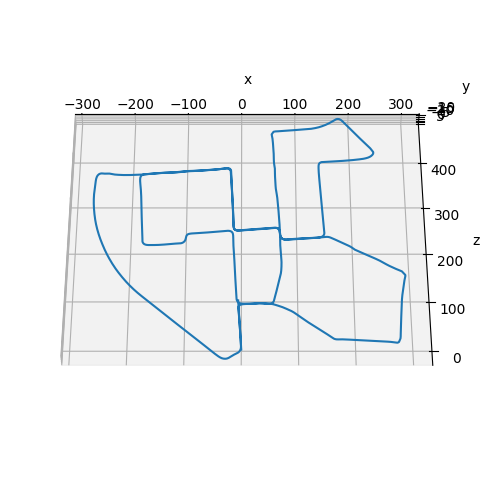

In [133]:
#visualizing sequence 00 (ground truth)
# gt size is (N, 3, 4) where last column is the translation vector
x_crds = gt[:, :, 3][:, 0]
y_crds = gt[:, :, 3][:, 1]
z_crds = gt[:, :, 3][:, 2]

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((np.ptp(x_crds), np.ptp(y_crds), np.ptp(z_crds)))
ax.plot(x_crds, y_crds, z_crds)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

In [134]:
# %matplotlib inline

<class 'numpy.ndarray'>


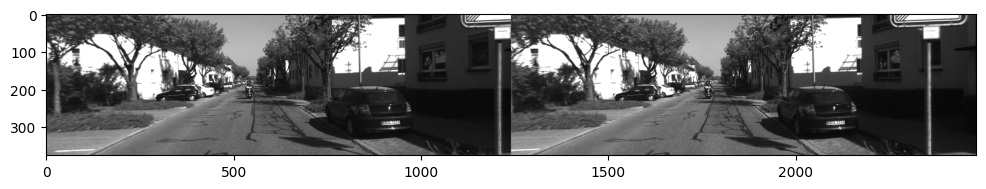

In [135]:
#taking a quick look on a sample image
sample_img_L = cv2.imread(os.path.join(sequence_path, "image_0", "000000.png"))
sample_img_R = cv2.imread(os.path.join(sequence_path, "image_1", "000000.png"))

print(type(sample_img_L))

plt.figure(figsize=(12,6))
plt.imshow(np.hstack((sample_img_L, sample_img_R)))


exploring the calibration file and point out the rectified projection matrix shit and how to invert them back to normal and would we like to do that

- Rectified Projection Matrices:
    - Distinction between global and local coordinate frames for the odometry problem vs the imaging problem

    - Regular vs. Rectified Configuration and what's the point?
    
    - is the rectified configuration invertable?

In [136]:
#loading calibration data
# cams 0 and 1 are the left and right cameras of the grey scale images
# cams 2 and 3 are the left and right cameras of the color images
# Tr is the transformation matrix from the velodyne to the camera

# Tr maps from the velodyne coordinate system to the camera coordinate system (3d to 3d)
# P is the projection matrix from the camera to the image plane (3d to 2d)

#notice that the P0 and P1 last rows are [0, 0, 1, 0] --> this extracts the Z coordinate for perpective normalization
#in the Tr matrix the last row is not like P) and P1 so they imply a transformation, when using the 
#P0 and P1 we normalize by the Z coordate to get the pixel value, we cnanot do that in the Tr matrix so it implies transformation

# if we want to use Tr we probably append a row of [0, 0, 0, 1] to it

calib_path = os.path.join(sequence_path, "calib.txt")
calib = pd.read_csv(calib_path, delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [137]:
# P0 is the projection matrix of the left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [138]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


The below cell caused alot of confusion for me, why did we not invert the extrensic paramater to get the world frame?

- extrensic parameter of a camera is a 3d to 3d projection between a point in world coorindates in 3d i bring it to the camera psition

**The Confusion:**  KITTI Convention -- it stores it the other way around stores it from camera to world, we ususlalyy see the world to camera

so in the dont cell we dont see an inverse. fuck this shit.

In [139]:
# This gives the camera's position in the WORLD frame (not camera frame).

R_t = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
R_t.dot(camera_origin_HC).round(4).reshape(-1,1)

#this is the camera position in the world frame

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [140]:
# this follows our pain in the a$$ for the kitti way of tranfomations
#when we have a point in 3d and want to bring it to the camera frame we dot product with T_HC_inv and vise versa
#we can also use these matrices without appending camera_origin_HC

T_HC = np.vstack([R_t, camera_origin_HC])
T_HC_inv = np.linalg.inv(T_HC)
print('Homogeneous transformation matrix:')
print(T_HC.round(4))
print('Inverted homogeneous transformation matrix:')
print(T_HC_inv.round(4))

Homogeneous transformation matrix:
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]
 [ 0.      0.      0.      1.    ]]
Inverted homogeneous transformation matrix:
[[ 1.      0.      0.     -0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [141]:
T_HC.dot(T_HC_inv)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## Dataset Handling

In [142]:
class Dataset_Handler():
    def __init__(self, sequence):
        #setting up directory paths
        self.dataset_path ="..\dataset"
        self.sequence_path = os.path.join(dataset_path, "sequences", sequence) #sequence: 00
        self.gt_data_path = os.path.join(dataset_path, "poses", sequence, sequence + ".txt")
        self.imgs_L_path = os.path.join(self.sequence_path, "image_0")
        self.imgs_R_path = os.path.join(self.sequence_path, "image_1")
        self.lidar_path = os.path.join(self.sequence_path, "velodyne")

        #fetch file names to iterate through
        self.img_L_files = os.listdir(self.imgs_L_path)
        self.img_R_files = os.listdir(self.imgs_R_path)
        self.Lidar_pcs = os.listdir(self.lidar_path) #lidar point clouds

        #fetching calibration matrices
        self.calib_path = os.path.join(self.sequence_path, "calib.txt")
        calib = pd.read_csv(self.calib_path, delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4)) #greyscale left camera
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4)) #greyscale right camera
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4)) #velodyne to left camera transformation

        #loading sample data to experiment with, without messing up generator iterator
        self.sample_img_L0 = cv2.imread(os.path.join(self.imgs_L_path, self.img_L_files[0]), 0)
        self.sample_img_L1 = cv2.imread(os.path.join(self.imgs_L_path, self.img_L_files[1]), 0)
        self.sample_img_R = cv2.imread(os.path.join(self.imgs_R_path, self.img_R_files[0]), 0)
        self.sample_pc = np.fromfile(os.path.join(self.lidar_path, self.Lidar_pcs[0]), dtype=np.float32, count = -1).reshape((-1,4))
        
        #setting up general dataset information
        self.num_frames = len(self.img_L_files)
        self.img_height = self.sample_img_L0.shape[0]
        self.img_width = self.sample_img_L0.shape[1]

        #setting up ground truth data
        gt_poses = pd.read_csv(self.gt_data_path, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4)) 

        for i in range(self.num_frames):
            self.gt[i,:,:] = np.array(gt_poses.iloc[i]).reshape((3, 4))

        #resetting generator iterator
        self.reset_frames()
    def reset_frames(self):
        self.img_L = (cv2.imread(os.path.join(self.imgs_L_path, name_L) , 0)
                      for name_L in self.img_L_files)
        self.img_R = (cv2.imread(os.path.join(self.imgs_R_path, name_R) , 0)
                for name_R in self.img_R_files)
        self.pcs = (np.fromfile(os.path.join(self.lidar_path, name_pc), dtype=np.float32, count = -1).reshape((-1,4))
                    for name_pc in self.Lidar_pcs)
        

In [143]:
handler = Dataset_Handler('00')

## Stereopsis

 We will attempt to track the pose of the vehicle using depth maps derived from stereopsis, then using visual odometry of the left camera to track motion at scale.

 Theoretically, we can derive relative rotation and translation between frames without needing structure information. As the process of estimating The Essential Matrix disentagled structure from motion.

 But this estimate will only be upto a projective transform. We will have a relative and unitless reconstruction, not a metric one.

 Incorporating depth information is a way for providing a metric reconstruction.

In [144]:
def compute_disparity_map(img_L, img_R, matcher='bm'):
    #disparity map is computer for the left image of the stereo pair

    #stereo matcher hyper-parameters
    sad_window = 6 # sum of absolute difference window size
    num_disparities = sad_window*16
    block_size = 11 # # Window size for matching (11×11 pixels)
    matcher_name = matcher
    num_channels = 1 #greyscale

    #setting up stereo matcher
    if matcher_name == 'bm': # block matching
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm': # semi-global block matching
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * num_channels * (block_size ** 2),
                                        P2 = 32 * num_channels * (block_size ** 2),
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    
    disp_map = matcher.compute(img_L, img_R).astype(np.float32)/16

    return disp_map

In [145]:
#loading data for experimentation
img_L0 = handler.sample_img_L0
img_L1 = handler.sample_img_L1
img_R0 = handler.sample_img_R
pc_0 = handler.sample_pc

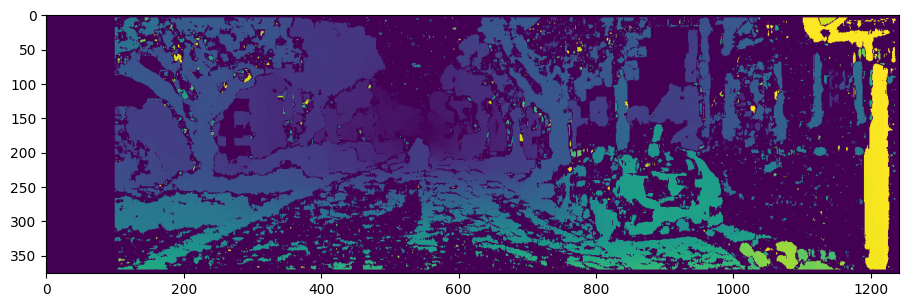

In [146]:
#compute disparity using StereoBM
disp_map_BM = compute_disparity_map(img_L0, img_R0, matcher='bm')
plt.figure(figsize=(11,7))
plt.imshow(disp_map_BM);

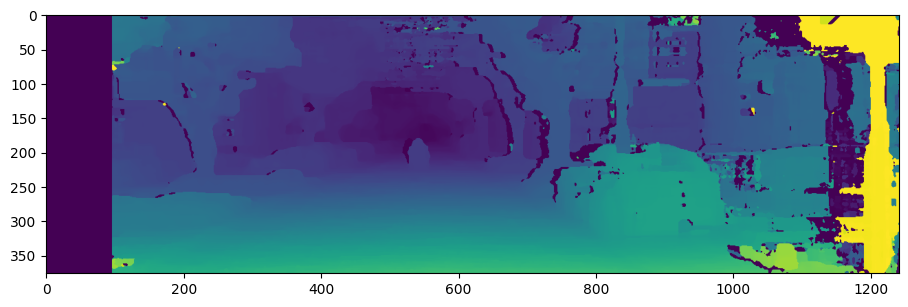

In [147]:
#compute disparity using stereoSGBM
disp_map_SGBM = compute_disparity_map(img_L0, img_R0, matcher='sgbm')
plt.figure(figsize=(11,7))
plt.imshow(disp_map_SGBM);

SGBM is generally slower than BM but produces more contiguous and smooth disparity maps, with less gaps in information

We can see that there is a gap of the left side of the image where the right camera did not have matching information. This will lead us to filter this gap out for downstream tasks to prevent useless computations

In [148]:
def decompose_proj_mat(p):

    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [149]:
#use triangulation to calculate depth from desparity map
def compute_depth_map(disp_left, k_left, t_left, t_right):
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    b = t_right[0] - t_left[0] #right - left since projection matrix is rectified
        
    # Avoid numerical instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [150]:
k_L, r_L, t_L = decompose_proj_mat(handler.P0)
k_R, r_R, t_R = decompose_proj_mat(handler.P1)

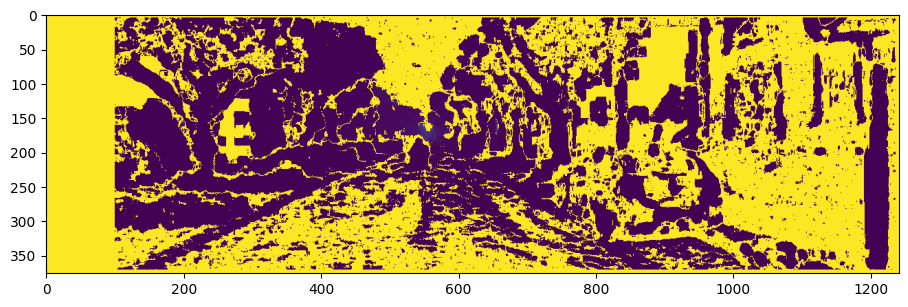

In [151]:
depth_map_BM = compute_depth_map(disp_map_BM, k_L, t_L, t_R)
plt.figure(figsize=(11,7))
plt.imshow(depth_map_BM);

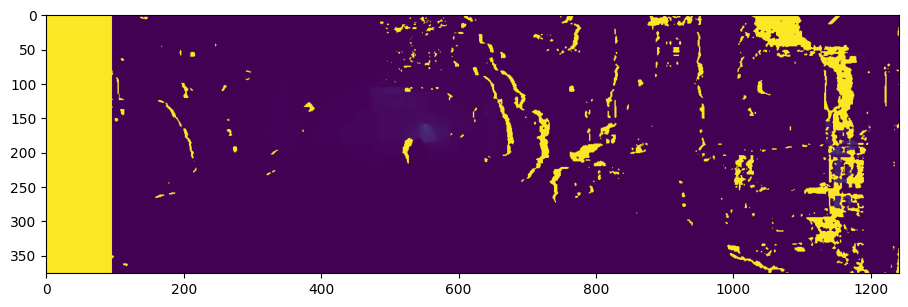

In [152]:
depth_map_SGBM = compute_depth_map(disp_map_SGBM, k_L, t_L, t_R)
plt.figure(figsize=(11,7))
plt.imshow(depth_map_SGBM);

In [153]:
print(depth_map_SGBM[0][0])
print(depth_map_SGBM.max())

3861.4479424599417
3861.4479424599417


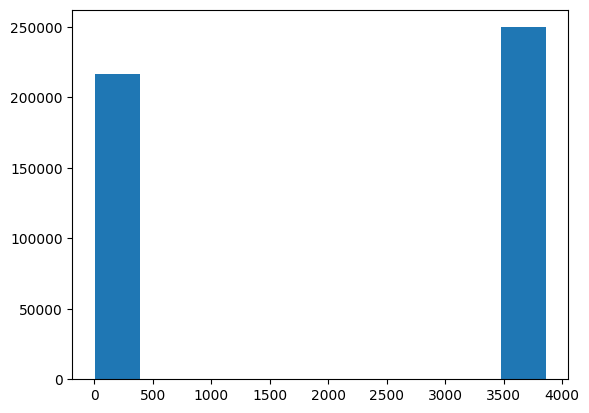

In [154]:
plt.hist(depth_map_BM.flatten());

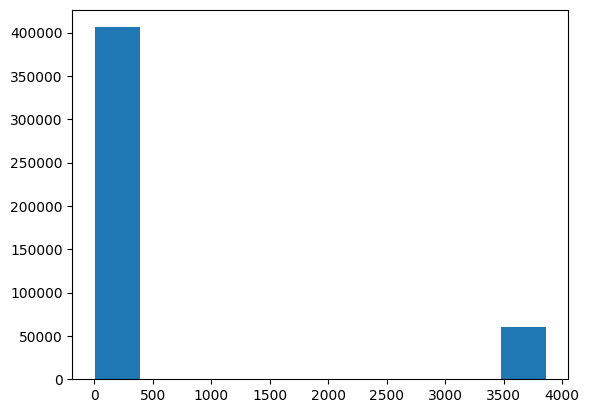

In [155]:
plt.hist(depth_map_SGBM.flatten());

In [156]:
#finding first non-max value to get dimensions of information gap
max_depth = depth_map_SGBM.max()
idx = 0 #first non-max value index
for i, pixel in enumerate(depth_map_SGBM[0]):
    if pixel < max_depth:
        idx = i
        break

idx

96

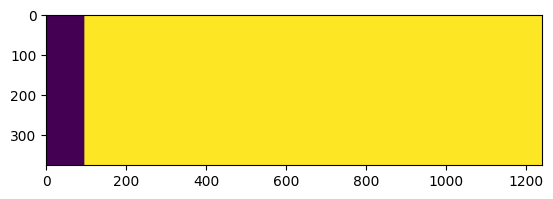

In [157]:
#constructing filteration mask
mask = np.zeros(img_L0.shape, dtype=np.uint8)
ymax = img_L0.shape[0]
xmax = img_L0.shape[1]
cv2.rectangle(mask, (idx,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [158]:
def stereo_to_depth(img_L, img_R, P0, P1, matcher='bm'):
    #takes stereo pair of images and returns a depth map for the left camera.as well as a filtration mask

    def _compute_disparity_map(img_L, img_R, matcher='bm'):
        #disparity map is computer for the left image of the stereo pair

        #stereo matcher hyper-parameters
        sad_window = 6
        num_disparities = sad_window*16
        block_size = 11
        matcher_name = matcher
        num_channels = 1 #greyscale

        #setting up stereo matcher
        if matcher_name == 'bm':
            matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                        blockSize=block_size
                                        )
            
        elif matcher_name == 'sgbm':
            matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                            minDisparity=0,
                                            blockSize=block_size,
                                            P1 = 8 * num_channels * (block_size ** 2),
                                            P2 = 32 * num_channels * (block_size ** 2),
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                        )
        
        disp_map = matcher.compute(img_L, img_R).astype(np.float32)/16

        return disp_map

    def _compute_depth_map(disp_left, k_left, t_left, t_right):
        # Get focal length of x axis for left camera
        f = k_left[0][0]
        
        # Calculate baseline of stereo pair
        b = t_right[0] - t_left[0] #right - left since projection matrix is rectified
            
        # Avoid numerical instability and division by zero
        disp_left[disp_left == 0.0] = 0.1
        disp_left[disp_left == -1.0] = 0.1
        
        # Make empty depth map then fill with depth
        depth_map = np.ones(disp_left.shape)
        depth_map = f * b / disp_left
    
        return depth_map
    
    def _construct_mask(depth_map):
        #finding first non-max value to get dimensions of information gap
        max_depth = depth_map.max()
        idx = 0 #first non-max value index
        for i, pixel in enumerate(depth_map[0]):
            if pixel < max_depth:
                idx = i
                break

        #constructing filteration mask
        mask = np.zeros(depth_map.shape, dtype=np.uint8)
        ymax = depth_map.shape[0]
        xmax = depth_map.shape[1]
        cv2.rectangle(mask, (idx,0), (xmax,ymax), (255), thickness = -1)

        return mask

    #compute disparity map
    disp_map = _compute_disparity_map(img_L, img_R, matcher)

    #decompose projection matrices
    k_L, _, t_L = decompose_proj_mat(P0)
    _, _, t_R = decompose_proj_mat(P1)
    #compute depth map
    depth_map = _compute_depth_map(disp_map, k_L, t_L, t_R)
    #construct filtration mask
    f_mask = _construct_mask(depth_map)
    
    return depth_map, f_mask

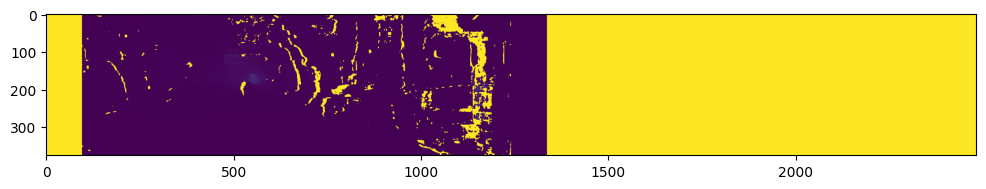

In [159]:
depth_map, f_mask = stereo_to_depth(img_L0, img_R0, handler.P0, handler.P1, matcher='sgbm')
plt.figure(figsize=(12,6))
plt.imshow(np.hstack(((depth_map/depth_map.max()), (f_mask/f_mask.max()))))

### Making Use of Lidar Data

#### Lidar Data Exploration

In [160]:
print('full pcloud shape', pc_0.shape)
trimmed_pcloud = pc_0[pc_0[:, 0] > 0]
print('trimmed pcloud shape', trimmed_pcloud.shape)

full pcloud shape (124668, 4)
trimmed pcloud shape (63141, 4)


In [161]:
handler.Tr.round(4)

array([[ 4.000e-04, -1.000e+00, -8.100e-03, -1.200e-02],
       [-7.200e-03,  8.100e-03, -9.999e-01, -5.400e-02],
       [ 1.000e+00,  5.000e-04, -7.200e-03, -2.922e-01]])

In [162]:
def pc_to_img(pc, imheight, imwidth, Tr, P0):
    '''
    Takes a pointcloud of shape Nx4 and projects it onto an image plane, first transforming
    the X, Y, Z coordinates of points to the camera frame with tranformation matrix Tr, then
    projecting them using camera projection matrix P0.
    '''

    #trimming points behind the car FOV
    pc = pc[pc[:, 0] > 0]

    #dropping reflectance information and converting to HC
    pc = np.hstack([pc[:, :3], np.ones(pc.shape[0]).reshape((-1,1))])

    #transform pointcloud into camera coordinate frame
    pc_2_Cam = Tr.dot(pc.T)
    
    #ignore any points behind the camera (probably redundant but just in case)
    pc_2_Cam = pc_2_Cam[:, pc_2_Cam[2] > 0]
    
    #extract depth
    depth = pc_2_Cam[2].copy()
    
    #project coordinates in camera frame to flat plane at Z=1 by dividing by Z (normalizing HC)
    pc_2_Cam /= pc_2_Cam[2]
    
    #converting to HC
    pc_2_Cam = np.vstack([pc_2_Cam, np.ones(pc_2_Cam.shape[1])])
    
    # Get pixel coordinates of X, Y, Z points in camera coordinate frame
    projection = P0.dot(pc_2_Cam)
    
    # Turn pixels into integers for indexing
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')

    # Limit pixel coordinates considered to those that fit on the image plane
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0)
                      )
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]

    #returning an image render of lidar depth values with the same dimensions as camera images
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]

    return render


In [163]:
lidar_depth = pc_to_img(pc_0, 
                          handler.img_height,
                          handler.img_width,
                          handler.Tr,
                          handler.P0
                         )

lidar_depth.shape

(376, 1241)

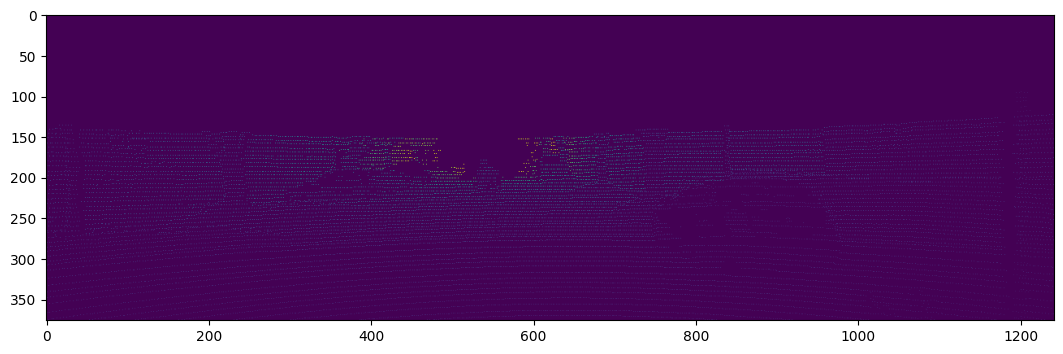

In [164]:
plt.figure(figsize=(13,5))
plt.imshow(lidar_depth);

In [165]:
for i, d in enumerate(depth_map[200:, :].flatten()):
    if lidar_depth[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d, 'Lidar Depth:', lidar_depth[200:, :].flatten()[i])
    if i > 1000:
        break

Stereo Depth: 24.040143190661478 Lidar Depth: 25.08251557273636
Stereo Depth: 36.99590898203593 Lidar Depth: 38.18529319193908
Stereo Depth: 37.672663414634144 Lidar Depth: 38.15661260397033
Stereo Depth: 37.672663414634144 Lidar Depth: 38.04491130916553
Stereo Depth: 38.13775802469136 Lidar Depth: 38.22929779114657
Stereo Depth: 38.37463850931677 Lidar Depth: 37.93287208133164
Stereo Depth: 38.61448 Lidar Depth: 37.970212888663504
Stereo Depth: 38.61448 Lidar Depth: 38.78230455441224
Stereo Depth: 39.10327088607595 Lidar Depth: 43.35304297366147
Stereo Depth: 52.806126495726495 Lidar Depth: 43.92954268130661
Stereo Depth: 56.68180550458715 Lidar Depth: 52.296451988896685
Stereo Depth: 57.206637037037034 Lidar Depth: 53.01673964440458
Stereo Depth: 57.206637037037034 Lidar Depth: 53.154098455093575
Stereo Depth: 57.74127850467289 Lidar Depth: 53.17143027237011
Stereo Depth: 57.74127850467289 Lidar Depth: 53.19275972156243
Stereo Depth: 57.74127850467289 Lidar Depth: 53.20793145785799
S

In [167]:
#determining the amount of image area that the lidar has given us depth information for
lidar_coverage = lidar_depth[lidar_depth > 0].size / lidar_depth.size
print(f"Lidar Coverage: {np.round(lidar_coverage, 2)*100} %")

Lidar Coverage: 4.0 %


#### Lidar Data Visualization

In [168]:
#to enable interactivity
# %matplotlib ipympl

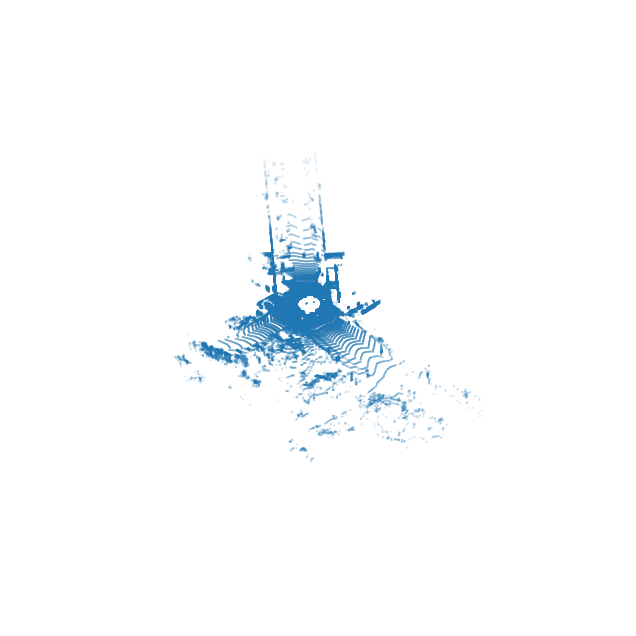

In [ ]:
# pc = handler.sample_pc
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# xs = pc[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
# ys = pc[:, 1]#[::20]
# zs = pc[:, 2]#[::20]

# ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
# ax.scatter(xs, ys, zs, s=0.01)
# ax.grid(False)
# ax.axis('off')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.view_init(elev=40, azim=180)

In [170]:
handler.reset_frames() #resetting generator

pc_frames = (pc_to_img(next(handler.pcs),
                                  handler.img_height,
                                  handler.img_width,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

stereo_l = handler.img_L
stereo_r = handler.img_R

In [ ]:
# for i in range(handler.num_frames // 20):
#     img_l = next(stereo_l)
#     img_r = next(stereo_r)
    
#     disp = compute_disparity_map(img_l, img_r, matcher='sgbm')
#     disp /= disp.max()
#     #disp = 1 - disp
#     disp = (disp*255).astype('uint8')
#     #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
#     pcloud = next(pc_frames)
#     pcloud /= pcloud.max()
#     pcloud = (pcloud*255).astype('uint8')
    
#     cv2.imshow('camera', img_l)
#     cv2.imshow('disparity', disp)
#     cv2.imshow('lidar', pcloud)
#     cv2.waitKey(1)
    
# plt.close()
# cv2.destroyAllWindows()

## Feature Extraction & Matching

In [172]:
def extract_features(image, detector='sift', mask=None):
    #Find keypoints and descriptors for the image
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [173]:
def match_features(des1, des2, matching='BF', detector='sift', k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

### Filtering Matched Based on Distance Ratios

We can see an informative graphic relating the quality of matches according to this metric below:

![SNOWFALL](lowe_ratio_test.png)

In [174]:
def filter_matches_distance(matches, dist_threshold):
    
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [175]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Number of matches before filtering: 3206
Number of matches after filtering: 446


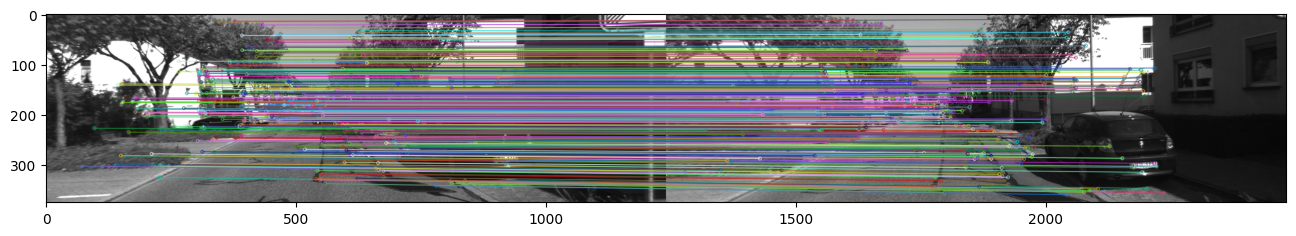

In [176]:
kp0, des0 = extract_features(img_L0, 'sift')
kp1, des1 = extract_features(img_L1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift')
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(img_L0, kp0, img_L1, kp1, matches)

In [177]:
def generate_matches(image1, image2, detector='sift', matching='BF', k=2, mask=None, dist_threshold=None):

    def _extract_features(image, detector='sift', mask=None):
        #Find keypoints and descriptors for the image
        if detector == 'sift':
            det = cv2.SIFT_create()
        elif detector == 'orb':
            det = cv2.ORB_create()
            
        kp, des = det.detectAndCompute(image, mask)
        
        return kp, des
    def _match_features(des1, des2, matching='BF', detector='sift', k=2):
    
        if matching == 'BF':
            if detector == 'sift':
                matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
            elif detector == 'orb':
                matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
            matches = matcher.knnMatch(des1, des2, k=k)
        elif matching == 'FLANN':
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            matcher = cv2.FlannBasedMatcher(index_params, search_params)
            matches = matcher.knnMatch(des1, des2, k=k)
        
        matches = sorted(matches, key = lambda x:x[0].distance)

        return matches

    def _filter_matches_distance(matches, dist_threshold):
        
        filtered_match = []
        for m, n in matches:
            if m.distance <= dist_threshold*n.distance:
                filtered_match.append(m)

        return filtered_match
    
    #extract features from stereo pair
    kp0, des0 = _extract_features(image1, detector, mask)
    kp1, des1 = _extract_features(image2, detector, mask)

    #match features
    matches = _match_features(des0, des1, matching, detector)
    #filter features
    if dist_threshold is not None:
        matches = _filter_matches_distance(matches, dist_threshold)
    
    return kp0, kp1, matches

## Estimating Relative Motion

Establishing the relative rotation and translation between the two frames can be done by estimating and subsequently decomposing The Fundamental/Essential Matrix. 

The Fundamenta/Essential Matrixm computation disentagles structure from motion, and by effect, can reconstruct the scene without the need of structure information.

But this would be only accurate upto a projective transform, rendering our reconstruction unitless and lacking metric scale.

Instead,we use the PnP Algorithm instead. Its use of structure information makes it able to provide a metric reconstruction.

In [178]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            #filter out missing depth information
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]

    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

## Putting It All Together!

### NOTE:

The SolvePnPRansac() function computes a pose that relates points in the global
coordinate frame to the camera's pose. 

We used the camera's pose in the first image
as the global coordinate frame, reconstruct 3D positions of the features in the
image using stereo depth estimation, then find a pose which relates the camera in
the next frame to those 3D points. 

When tracking the vehicle pose over time, what we
actually want is to relate the points in the camera's coordinate frame to the global
frame, so we want the opposite (inverse) of the transformation matrix provided to us
by the SolvePnPRansac function. 

In [179]:
def visual_odometry(handler, lidar=False, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=False, depth_type='stereo', subset=None, plot=False):
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), matching))

    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')

    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')

    imheight = handler.img_height
    imwidth = handler.img_width

    # Establish Total homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]

    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, _, _ = decompose_proj_mat(handler.P0)

    handler.reset_frames()
    image_plus1 = next(handler.img_L)

    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now() #timing frame computation time

        # Get our stereo images for depth estimation
        
        image_left = image_plus1
        image_right = next(handler.img_R)
        # Get next frame in the left camera for visual odometry
        image_plus1 = next(handler.img_L)
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth, f_mask = stereo_to_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None

        if lidar:
            pointcloud = next(handler.pcs)
            lidar_depth = pc_to_img(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]

        kp0, kp1, matches= generate_matches(image_left, image_plus1, detector, matching, k=2, mask=f_mask, dist_threshold=filter_match_distance)

        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)

        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T

        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            ax.plot(xs, ys, zs, c='chartreuse')
            #plt.pause(1e-32)
    if plot:
        plt.close()

    return trajectory       

In [180]:
def calculate_error(ground_truth, estimated, error_type='mse'):
    nframes_est = estimated.shape[0]
    
    def _get_mse(ground_truth, estimated):
        # Use :nframes_est (slice) instead of nframes_est (single index)
        se = np.sqrt((ground_truth[:nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[:nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[:nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def _get_mae(ground_truth, estimated):
        # Use :nframes_est (slice) instead of nframes_est (single index)
        ae = np.sqrt((ground_truth[:nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[:nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[:nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    mae = _get_mae(ground_truth, estimated)
    mse = _get_mse(ground_truth, estimated)
    rmse = np.sqrt(mse)
    return {'mae': mae,
            'rmse': rmse,
            'mse': mse}

### No LIDAR depth correction, StereoSGBM disparity matching

In [181]:
# # Let's see how we do with no lidar, using the SGBM stereo matcher
# start = datetime.datetime.now()
# trajectory_nolidar_sgbm = visual_odometry(handler,
#                                           lidar=False,
#                                           filter_match_distance=0.5, 
#                                           detector='sift',
#                                         #   matching='FLANN',
#                                           stereo_matcher='sgbm',
#                                           mask=True,     
#                                           #subset=500,
#                                           plot=False)
# end = datetime.datetime.now()
# print('Time to perform odometry:', end-start)

In [182]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot(trajectory_nolidar_sgbm[:, :, 3][:, 0], 
#         trajectory_nolidar_sgbm[:, :, 3][:, 1], 
#         trajectory_nolidar_sgbm[:, :, 3][:, 2], label='estimated', color='red')

# ax.plot(handler.gt[:, :, 3][:, 0], 
#         handler.gt[:, :, 3][:, 1], 
#         handler.gt[:, :, 3][:, 2], label='ground truth')

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.view_init(elev=-20, azim=270)

In [183]:
# calculate_error(handler.gt, trajectory_nolidar_sgbm)

### Brief Comments:

As you see, the algorithm managed to replicate the track contour quiet nicely, but it suffers from significant drift.

This is because the process, at the core, is dependent on the stereo depth estimates which suffers from significant errors.

This process can be imporved by a myriad of ways, but here are a few of them:

- Graph Pose Optimization (Loop Closure constraints)
- Sensor Fusion Algorithms (Kalman filter, particle filter,..) with other more accurate sensors (e.g. Lidar)
- Bundle adjustment
- Cross Validating with an existing map


## LiDAR Odometry with ICP

Instead of using LiDAR just for depth at feature points, we can run a completely separate odometry pipeline using ICP (Iterative Closest Point) to align consecutive LiDAR scans.

**Key Differences from Visual Odometry:**
- Uses ALL LiDAR points (~100,000 per scan) instead of just 20-50 at feature locations
- No image features involved - purely geometric alignment
- Better translation accuracy, can struggle with rotation in certain scenarios

This will give us a second odometry estimate that we can later fuse with Visual Odometry using a Kalman Filter.

In [184]:
# Make sure Open3D is installed
# !pip install open3d
import open3d as o3d
print('Open3D version:', o3d.__version__)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Open3D version: 0.19.0


In [210]:
def run_icp(source_pcd, target_pcd, max_correspondence_distance=1.0, init_transform=None):
    """
    Run ICP between source and target point clouds.
    
    Args:
        source_pcd: Point cloud to transform (current frame)
        target_pcd: Reference point cloud (previous frame)
        max_correspondence_distance: Maximum distance for point matching
        init_transform: Initial transformation guess (default: identity)
    
    Returns:
        4x4 transformation matrix, fitness score, inlier RMSE
    """
    if init_transform is None:
        init_transform = np.eye(4)
    
    # First, do coarse alignment with larger threshold
    result_coarse = o3d.pipelines.registration.registration_icp(
        source=source_pcd,
        target=target_pcd,
        max_correspondence_distance=max_correspondence_distance * 2,
        init=init_transform,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        criteria=o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=20)
    )
    
    # Then refine with point-to-plane and tighter threshold
    result = o3d.pipelines.registration.registration_icp(
        source=source_pcd,
        target=target_pcd,
        max_correspondence_distance=max_correspondence_distance,
        init=result_coarse.transformation,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        criteria=o3d.pipelines.registration.ICPConvergenceCriteria(
            max_iteration=50,
            relative_fitness=1e-7,
            relative_rmse=1e-7
        )
    )
    
    return result.transformation, result.fitness, result.inlier_rmse

In [211]:
def preprocess_point_cloud(pc, voxel_size=0.3, Tr=None, remove_ground=True, ground_threshold=0.3):
    """
    Convert numpy array to Open3D point cloud and preprocess.
    
    Args:
        pc: Nx4 numpy array (x, y, z, reflectance)
        voxel_size: Downsampling voxel size (meters)
        Tr: 3x4 transformation matrix from LiDAR to camera frame
        remove_ground: If True, filter out ground plane points
        ground_threshold: Height threshold for ground removal (in camera frame, Y axis)
    
    Returns:
        Open3D point cloud, downsampled with normals estimated
    """
    # Keep only points in front of the vehicle (x > 0 in LiDAR frame)
    # Also limit range to avoid far noisy points
    mask = (pc[:, 0] > 1.0) & (pc[:, 0] < 80.0)  # 1-80m range
    pc = pc[mask]
    
    # Transform to camera coordinate frame if Tr is provided
    if Tr is not None:
        pc_hom = np.hstack([pc[:, :3], np.ones((pc.shape[0], 1))])
        pc_cam = (Tr @ pc_hom.T).T
        pc_xyz = pc_cam
    else:
        pc_xyz = pc[:, :3]
    
    # Remove ground plane points (in camera frame, Y points down, so ground has large Y)
    # Also remove ceiling/sky points
    if remove_ground:
        # Keep points that are not ground (Y not too large) and not sky (Y not too negative)
        height_mask = (pc_xyz[:, 1] > -2.0) & (pc_xyz[:, 1] < 1.5)
        pc_xyz = pc_xyz[height_mask]
    
    if len(pc_xyz) < 100:
        print("Warning: Very few points after filtering!")
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc_xyz)
    
    # Downsample
    pcd = pcd.voxel_down_sample(voxel_size)
    
    # Estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30)
    )
    
    return pcd

In [212]:
def lidar_odometry(handler, voxel_size=0.3, max_correspondence=1.0, subset=None):
    """
    LiDAR Odometry using ICP with motion prediction.
    
    Args:
        handler: Dataset_Handler instance
        voxel_size: Downsampling voxel size in meters (smaller = more accurate but slower)
        max_correspondence: Maximum distance for ICP point matching in meters
        subset: Number of frames to process (None = all frames)
    
    Returns:
        trajectory: Nx3x4 array of poses (same format as ground truth)
    """
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    
    print(f'Running LiDAR Odometry on {num_frames} frames')
    print(f'Voxel size: {voxel_size}m, Max correspondence: {max_correspondence}m')
    print('With ground plane filtering and motion prediction')
    
    # Initialize
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    
    # For motion prediction
    last_T_icp = np.eye(4)
    
    # Reset and get first frame
    handler.reset_frames()
    pc_prev = next(handler.pcs)
    pcd_prev = preprocess_point_cloud(pc_prev, voxel_size, Tr=handler.Tr, remove_ground=True)
    
    fitness_scores = []
    
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
        pc_curr = next(handler.pcs)
        pcd_curr = preprocess_point_cloud(pc_curr, voxel_size, Tr=handler.Tr, remove_ground=True)
        
        # Use last transformation as initial guess (motion prediction)
        # This assumes roughly constant velocity
        init_guess = last_T_icp
        
        # Run ICP with motion prediction
        T_icp, fitness, rmse = run_icp(pcd_curr, pcd_prev, max_correspondence, init_transform=init_guess)
        
        # Check if ICP succeeded (fitness > threshold)
        if fitness < 0.3:
            print(f"Warning frame {i+1}: Low fitness {fitness:.3f}, using motion prediction")
            T_icp = last_T_icp  # Fall back to predicted motion
        else:
            last_T_icp = T_icp  # Update motion model
        
        fitness_scores.append(fitness)
        
        # Accumulate transformation
        T_tot = T_tot @ T_icp
        trajectory[i + 1, :, :] = T_tot[:3, :]
        
        pcd_prev = pcd_curr
        
        end = datetime.datetime.now()
        
        if (i + 1) % 100 == 0 or i == 0:
            print(f'Frame {i + 1}/{num_frames - 1}, '
                  f'Fitness: {fitness:.4f}, RMSE: {rmse:.4f}, '
                  f'Points: {len(pcd_curr.points)}, Time: {end - start}')
    
    print(f'\nLiDAR Odometry complete!')
    print(f'Average fitness: {np.mean(fitness_scores):.4f}, Min: {np.min(fitness_scores):.4f}')
    
    return trajectory

In [217]:
# Run LiDAR odometry with improved parameters
# Ground filtering + motion prediction + coarse-to-fine ICP

start = datetime.datetime.now()
trajectory_lidar = lidar_odometry(
    handler,
    voxel_size=0.3,            # Finer voxels for better accuracy
    max_correspondence=1.0,     # Tighter matching threshold
    subset=None                 # Process all frames (use 500 for quick test)
)
end = datetime.datetime.now()
print(f'\nTotal time: {end - start}')

Running LiDAR Odometry on 4541 frames
Voxel size: 0.3m, Max correspondence: 1.0m
With ground plane filtering and motion prediction
Frame 1/4540, Fitness: 0.9688, RMSE: 0.2013, Points: 5103, Time: 0:00:00.157246
Frame 100/4540, Fitness: 0.9968, RMSE: 0.1820, Points: 7745, Time: 0:00:00.065735
Frame 200/4540, Fitness: 0.9795, RMSE: 0.2118, Points: 7251, Time: 0:00:00.070211
Frame 300/4540, Fitness: 0.9800, RMSE: 0.2009, Points: 5913, Time: 0:00:00.040170
Frame 400/4540, Fitness: 0.9567, RMSE: 0.2571, Points: 6449, Time: 0:00:00.092534
Frame 500/4540, Fitness: 0.9642, RMSE: 0.2213, Points: 5498, Time: 0:00:00.071777
Frame 600/4540, Fitness: 0.9963, RMSE: 0.1680, Points: 4292, Time: 0:00:00.065241
Frame 700/4540, Fitness: 0.9943, RMSE: 0.2233, Points: 5744, Time: 0:00:00.091781
Frame 800/4540, Fitness: 0.9496, RMSE: 0.2410, Points: 4942, Time: 0:00:00.066693
Frame 900/4540, Fitness: 0.9594, RMSE: 0.2316, Points: 5474, Time: 0:00:00.043815
Frame 1000/4540, Fitness: 0.9860, RMSE: 0.2325, Poi

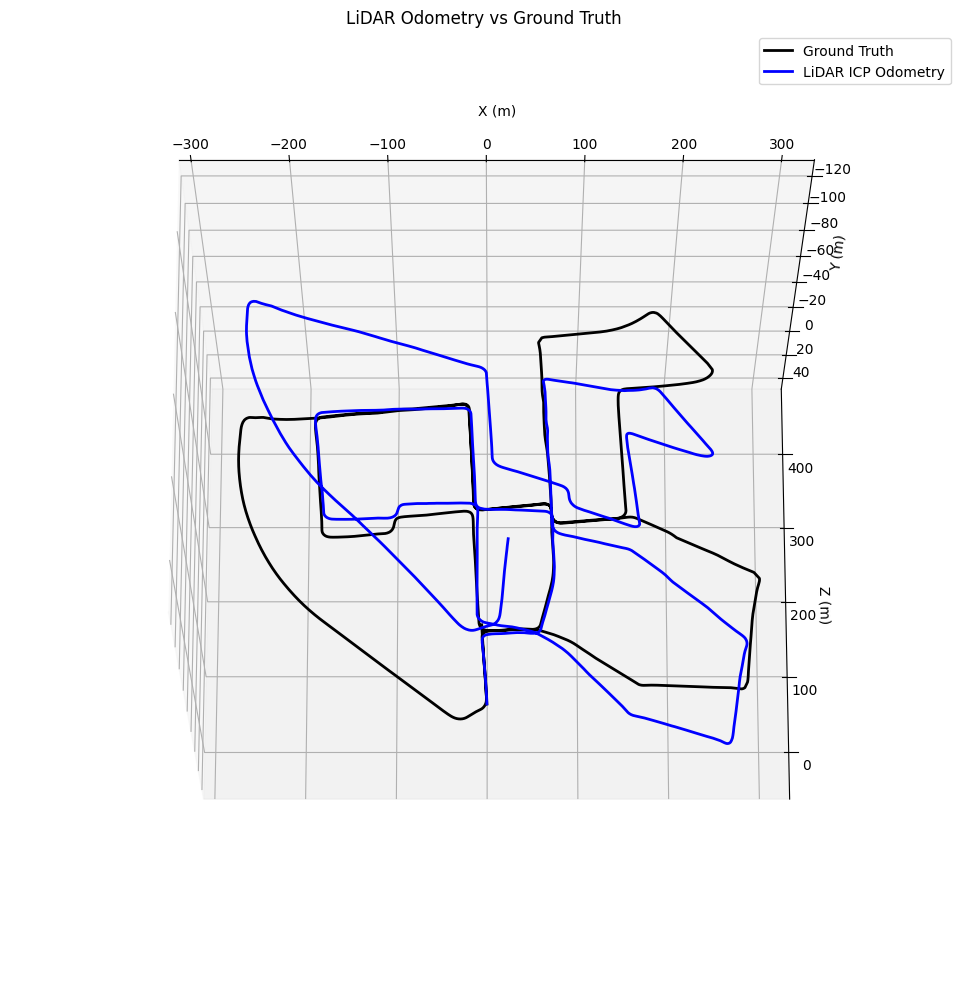

In [218]:
# Plot LiDAR odometry trajectory vs ground truth
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Ground truth
num_frames_est = trajectory_lidar.shape[0]
ax.plot(handler.gt[:num_frames_est, 0, 3], 
        handler.gt[:num_frames_est, 1, 3], 
        handler.gt[:num_frames_est, 2, 3], 
        'k-', label='Ground Truth', linewidth=2)

# LiDAR odometry
ax.plot(trajectory_lidar[:, 0, 3], 
        trajectory_lidar[:, 1, 3], 
        trajectory_lidar[:, 2, 3], 
        'b-', label='LiDAR ICP Odometry', linewidth=2)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
ax.view_init(elev=-20, azim=270)
plt.title('LiDAR Odometry vs Ground Truth')
plt.tight_layout()
plt.show()

In [219]:
# Calculate error metrics for LiDAR odometry
lidar_error = calculate_error(handler.gt, trajectory_lidar)
print('LiDAR Odometry Error:')
print(f"  MAE:  {lidar_error['mae']:.4f} m")
print(f"  RMSE: {lidar_error['rmse']:.4f} m")
print(f"  MSE:  {lidar_error['mse']:.4f} m²")

LiDAR Odometry Error:
  MAE:  38.8096 m
  RMSE: 54.2423 m
  MSE:  2942.2286 m²


In [ ]:
# Compare LiDAR odometry with Visual Odometry (if available)
# Run this cell after you have both trajectories

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

num_frames_plot = min(trajectory_lidar.shape[0], 
                      trajectory_nolidar_sgbm.shape[0] if 'trajectory_nolidar_sgbm' in dir() else trajectory_lidar.shape[0])

# Ground truth
ax.plot(handler.gt[:num_frames_plot, 0, 3], 
        handler.gt[:num_frames_plot, 1, 3], 
        handler.gt[:num_frames_plot, 2, 3], 
        'k-', label='Ground Truth', linewidth=2)

# LiDAR odometry
ax.plot(trajectory_lidar[:num_frames_plot, 0, 3], 
        trajectory_lidar[:num_frames_plot, 1, 3], 
        trajectory_lidar[:num_frames_plot, 2, 3], 
        'b-', label='LiDAR ICP', linewidth=2)

# Visual odometry (if available)
if 'trajectory_nolidar_sgbm' in dir():
    ax.plot(trajectory_nolidar_sgbm[:num_frames_plot, 0, 3], 
            trajectory_nolidar_sgbm[:num_frames_plot, 1, 3], 
            trajectory_nolidar_sgbm[:num_frames_plot, 2, 3], 
            'r-', label='Visual Odometry (SGBM)', linewidth=2)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
ax.view_init(elev=-20, azim=270)
plt.title('Odometry Comparison: LiDAR ICP vs Visual Odometry vs Ground Truth')
plt.tight_layout()
plt.show()

# Print comparison
print('\n=== Error Comparison ===')
print(f"LiDAR ICP - MAE: {lidar_error['mae']:.4f}m, RMSE: {lidar_error['rmse']:.4f}m")
if 'trajectory_nolidar_sgbm' in dir():
    vo_error = calculate_error(handler.gt, trajectory_nolidar_sgbm)
    print(f"Visual Odometry - MAE: {vo_error['mae']:.4f}m, RMSE: {vo_error['rmse']:.4f}m")

### Next Steps: Sensor Fusion with Kalman Filter

Now that we have two independent odometry estimates:
1. **Visual Odometry** (SGBM stereo depth) - drifts over time but good rotation
2. **LiDAR Odometry** (ICP) - better translation accuracy

We can fuse them using an Extended Kalman Filter (EKF) to get the best of both worlds:
- Use constant velocity model for prediction
- Use both VO and LiDAR poses as observations with different noise covariances
- The filter will weight each measurement based on their uncertainties

## Sensor Fusion with Extended Kalman Filter

Now we fuse Visual Odometry and LiDAR Odometry using an EKF:
- **Motion Model**: Constant velocity (physics-based prediction)
- **Observations**: Both VO and LiDAR poses (weighted by uncertainty)

This treats both sensors symmetrically - neither is "better", they just have different uncertainties.

In [233]:
class EKF_Fusion:
    """
    Extended Kalman Filter for fusing VO and LiDAR odometry.
    
    State: [x, y, z, vx, vy, vz] (position and velocity)
    """
    
    def __init__(self, dt=0.1):
        """
        Initialize EKF.
        
        Args:
            dt: Time step between frames (seconds)
        """
        self.dt = dt
        
        # State vector: [x, y, z, vx, vy, vz]
        self.state = np.zeros(6)
        
        # State covariance matrix (uncertainty in state)
        self.P = np.eye(6) * 1.0  # Initial uncertainty
        
        # State transition matrix (constant velocity model)
        self.F = np.array([
            [1, 0, 0, dt, 0,  0 ],
            [0, 1, 0, 0,  dt, 0 ],
            [0, 0, 1, 0,  0,  dt],
            [0, 0, 0, 1,  0,  0 ],
            [0, 0, 0, 0,  1,  0 ],
            [0, 0, 0, 0,  0,  1 ]
        ])
        
        # Process noise covariance (how much we trust motion model)
        # Higher values = less trust in constant velocity, more responsive
        q_pos = 0.1    # Position process noise
        q_vel = 0.5    # Velocity process noise
        self.Q = np.diag([q_pos, q_pos, q_pos, q_vel, q_vel, q_vel])
        
        # Observation matrix (we observe position)
        self.H = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0]
        ])
        
        # Measurement noise for VO (higher = less trust)
        # VO is less accurate in depth (z), more accurate in x, y
        self.R_vo = np.diag([2.0, 2.0, 5.0])  # [x, y, z] variance
        
        # Measurement noise for LiDAR (generally more accurate)
        self.R_lidar = np.diag([3.0, 3.0, 3.0])  # [x, y, z] variance
    
    def predict(self):
        """
        Prediction step: propagate state using motion model.
        """
        # Predict state
        self.state = self.F @ self.state
        
        # Predict covariance
        self.P = self.F @ self.P @ self.F.T + self.Q
        
        return self.state[:3]  # Return predicted position
    
    def update(self, measurement, R):
        """
        Update step: correct prediction with measurement.
        
        Args:
            measurement: [x, y, z] position measurement
            R: Measurement noise covariance matrix
        """
        # Innovation (measurement residual)
        z = np.array(measurement)
        y = z - self.H @ self.state
        
        # Innovation covariance
        S = self.H @ self.P @ self.H.T + R
        
        # Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # Update state
        self.state = self.state + K @ y
        
        # Update covariance
        I = np.eye(6)
        self.P = (I - K @ self.H) @ self.P
        
        return self.state[:3]  # Return updated position
    
    def update_vo(self, position):
        """Update with VO measurement."""
        return self.update(position, self.R_vo)
    
    def update_lidar(self, position):
        """Update with LiDAR measurement."""
        return self.update(position, self.R_lidar)
    
    def get_position(self):
        """Get current position estimate."""
        return self.state[:3]
    
    def get_velocity(self):
        """Get current velocity estimate."""
        return self.state[3:6]

In [242]:
def estimate_motion(match, kp1, kp2, k, depth1=None, lidar_depth=None, lidar_only=False, max_depth=3000):
    """
    Estimate motion between two frames using PnP or Essential Matrix.

    Args:
        match: List of cv2.DMatch objects
        kp1, kp2: Keypoints from frame 1 and 2
        k: Camera intrinsic matrix
        depth1: Stereo depth map
        lidar_depth: LiDAR projected depth map (sparse)
        lidar_only: If True, only use keypoints with LiDAR depth
        max_depth: Maximum valid depth

    Returns:
        rmat, tvec, image1_points, image2_points
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))

    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])
    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []
        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            u_int, v_int = int(u), int(v)

            # If lidar_only mode, ONLY use points with LiDAR depth
            if lidar_only and lidar_depth is not None:
                z = lidar_depth[v_int, u_int]
                # Skip points without LiDAR coverage
                if z <= 0:
                    delete.append(i)
                    continue
            else:
                # Use combined depth (LiDAR where available, else stereo)
                z = depth1[v_int, u_int]

            # Filter out missing/invalid depth information
            if z > max_depth or z <= 0:
                delete.append(i)
                continue

            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z * (u - cx) / fx
            y = z * (v - cy) / fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)

        # Need minimum points for PnP
        if len(object_points) < 6:
            print(f"Warning: Only {len(object_points)} points with LiDAR depth, falling back to stereo")
            # Recursive call without lidar_only restriction
            return estimate_motion(match, kp1, kp2, k, depth1, None, False, max_depth)

        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)

        # if lidar_only:
            # print(f'LiDAR-only PnP: {len(inliers)}/{len(object_points)} inliers from {len(match)} matches')

        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    else:
        # With no depth provided, use essential matrix decomposition instead
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)

    return rmat, tvec, image1_points, image2_points


In [243]:
def fused_odometry(handler, vo_params=None, lidar_params=None, subset=None, vo_use_lidar_depth=True):
    """
    Run Visual Odometry and LiDAR Odometry together with EKF fusion.
    
    Args:
        handler: Dataset handler
        vo_params: Dict of VO parameters
        lidar_params: Dict of LiDAR odometry parameters
        subset: Number of frames to process
        vo_use_lidar_depth: If True, VO uses LiDAR depth instead of SGBM stereo
    
    Returns:
        trajectory_fused: Fused trajectory
        trajectory_vo: VO-only trajectory
        trajectory_lidar: LiDAR-only trajectory
    """
    # Default parameters
    if vo_params is None:
        vo_params = {'detector': 'sift', 'matching': 'BF', 
                     'filter_match_distance': 0.5, 'stereo_matcher': 'sgbm'}
    if lidar_params is None:
        lidar_params = {'voxel_size': 0.3, 'max_correspondence': 1.0}
    
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    
    print(f'Running Fused Odometry on {num_frames} frames')
    print(f'VO using {"LiDAR depth" if vo_use_lidar_depth else "SGBM stereo depth"}')
    print(f'LiDAR params: {lidar_params}')
    
    # Initialize trajectories
    trajectory_fused = np.zeros((num_frames, 3, 4))
    trajectory_vo = np.zeros((num_frames, 3, 4))
    trajectory_lidar = np.zeros((num_frames, 3, 4))
    
    # Initialize poses
    T_vo = np.eye(4)
    T_lidar = np.eye(4)
    T_fused = np.eye(4)
    
    trajectory_fused[0] = T_fused[:3, :]
    trajectory_vo[0] = T_vo[:3, :]
    trajectory_lidar[0] = T_lidar[:3, :]
    
    # Initialize EKF (dt ~ 0.1s for 10Hz KITTI)
    ekf = EKF_Fusion(dt=0.1)
    
    # Get camera intrinsics
    k_left, _, _ = decompose_proj_mat(handler.P0)
    
    imheight = handler.img_height
    imwidth = handler.img_width
    
    # Reset generators
    handler.reset_frames()
    
    # Get first frames
    image_left = next(handler.img_L)
    image_right = next(handler.img_R)
    pc_prev = next(handler.pcs)
    pcd_prev = preprocess_point_cloud(pc_prev, lidar_params['voxel_size'], Tr=handler.Tr)
    
    # For motion prediction in LiDAR ICP
    last_T_icp = np.eye(4)
    
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
        # Get next frames
        image_left_next = next(handler.img_L)
        image_right_next = next(handler.img_R)
        pc_curr = next(handler.pcs)
        
        # ============ GET LIDAR DEPTH MAP ============
        # Project LiDAR to image for VO depth (using your pc_to_img function)
        lidar_depth_map = pc_to_img(pc_prev, 
                                    imheight=imheight, 
                                    imwidth=imwidth, 
                                    Tr=handler.Tr, 
                                    P0=handler.P0)
        
        # ============ VISUAL ODOMETRY ============
        if vo_use_lidar_depth:
            # Use LiDAR depth only (your lidar_only mode)
            # Still need stereo for the mask
            depth, f_mask = stereo_to_depth(image_left, image_right, 
                                            handler.P0, handler.P1, 
                                            matcher=vo_params['stereo_matcher'])
            
            # Match features
            kp0, kp1, matches = generate_matches(image_left, image_left_next,
                                                 detector=vo_params['detector'],
                                                 matching=vo_params['matching'],
                                                 mask=f_mask,
                                                 dist_threshold=vo_params['filter_match_distance'])
            
            # Estimate motion using LiDAR depth only
            rmat_vo, tvec_vo, _, _ = estimate_motion(
                matches, kp0, kp1, k_left, 
                depth1=depth,           # Fallback depth
                lidar_depth=lidar_depth_map,
                lidar_only=True         # Use only points with LiDAR depth
            )
        else:
            # Original SGBM stereo depth mode
            depth, f_mask = stereo_to_depth(image_left, image_right, 
                                            handler.P0, handler.P1, 
                                            matcher=vo_params['stereo_matcher'])
            
            kp0, kp1, matches = generate_matches(image_left, image_left_next,
                                                 detector=vo_params['detector'],
                                                 matching=vo_params['matching'],
                                                 mask=f_mask,
                                                 dist_threshold=vo_params['filter_match_distance'])
            
            rmat_vo, tvec_vo, _, _ = estimate_motion(matches, kp0, kp1, k_left, depth1=depth)
        
        # Build VO transformation
        T_delta_vo = np.eye(4)
        T_delta_vo[:3, :3] = rmat_vo
        T_delta_vo[:3, 3] = tvec_vo.flatten()
        
        # Accumulate VO pose
        T_vo = T_vo @ np.linalg.inv(T_delta_vo)
        trajectory_vo[i + 1] = T_vo[:3, :]
        
        # ============ LIDAR ODOMETRY (ICP) ============
        pcd_curr = preprocess_point_cloud(pc_curr, lidar_params['voxel_size'], Tr=handler.Tr)
        
        # Run ICP with motion prediction
        T_icp, fitness, rmse = run_icp(pcd_curr, pcd_prev, 
                                       lidar_params['max_correspondence'],
                                       init_transform=last_T_icp)
        
        if fitness > 0.3:
            last_T_icp = T_icp
        
        # Accumulate LiDAR pose
        T_lidar = T_lidar @ T_icp
        trajectory_lidar[i + 1] = T_lidar[:3, :]
        
        # ============ EKF FUSION ============
        # Predict step
        ekf.predict()
        
        # Update with VO position
        vo_position = T_vo[:3, 3]
        ekf.update_vo(vo_position)
        
        # Update with LiDAR position
        lidar_position = T_lidar[:3, 3]
        ekf.update_lidar(lidar_position)
        
        # Get fused position
        fused_position = ekf.get_position()
        
        # Build fused transformation (use VO rotation, fused position)
        T_fused[:3, :3] = T_vo[:3, :3]  # Use VO rotation
        T_fused[:3, 3] = fused_position
        trajectory_fused[i + 1] = T_fused[:3, :]
        
        # Update for next iteration
        image_left = image_left_next
        image_right = image_right_next
        pc_prev = pc_curr
        pcd_prev = pcd_curr
        
        end = datetime.datetime.now()
        
        if (i + 1) % 100 == 0 or i == 0:
            print(f'Frame {i + 1}/{num_frames - 1}, '
                  f'ICP fitness: {fitness:.3f}, Time: {end - start}')
    
    print('\nFused Odometry complete!')
    
    return trajectory_fused, trajectory_vo, trajectory_lidar

### Run Sensor Fusion

This runs VO and LiDAR odometry together, fusing them with the EKF at each frame.

In [244]:
# Run fused odometry with LiDAR depth for VO
start = datetime.datetime.now()

trajectory_fused, trajectory_vo_new, trajectory_lidar_new = fused_odometry(
    handler,
    vo_params={'detector': 'sift', 'matching': 'BF', 
               'filter_match_distance': 0.5, 'stereo_matcher': 'sgbm'},
    lidar_params={'voxel_size': 0.3, 'max_correspondence': 1.0},
    subset=None,              # Set to 500 for quick test
    vo_use_lidar_depth=True   # Use LiDAR depth for VO instead of SGBM
)

end = datetime.datetime.now()
print(f'\nTotal time: {end - start}')

Running Fused Odometry on 4541 frames
VO using LiDAR depth
LiDAR params: {'voxel_size': 0.3, 'max_correspondence': 1.0}
Frame 1/4540, ICP fitness: 0.969, Time: 0:00:00.370441
Frame 100/4540, ICP fitness: 0.997, Time: 0:00:00.336012
Frame 200/4540, ICP fitness: 0.979, Time: 0:00:00.326764
Frame 300/4540, ICP fitness: 0.980, Time: 0:00:00.309172
Frame 400/4540, ICP fitness: 0.957, Time: 0:00:00.284451
Frame 500/4540, ICP fitness: 0.964, Time: 0:00:00.364383
Frame 600/4540, ICP fitness: 0.996, Time: 0:00:00.316840
Frame 700/4540, ICP fitness: 0.994, Time: 0:00:00.341293
Frame 800/4540, ICP fitness: 0.950, Time: 0:00:00.377316
Frame 900/4540, ICP fitness: 0.959, Time: 0:00:00.404603
Frame 1000/4540, ICP fitness: 0.986, Time: 0:00:00.404135
Frame 1100/4540, ICP fitness: 0.970, Time: 0:00:00.344179
Frame 1200/4540, ICP fitness: 0.961, Time: 0:00:00.345587
Frame 1300/4540, ICP fitness: 0.985, Time: 0:00:00.309389
Frame 1400/4540, ICP fitness: 0.987, Time: 0:00:00.335925
Frame 1500/4540, ICP f

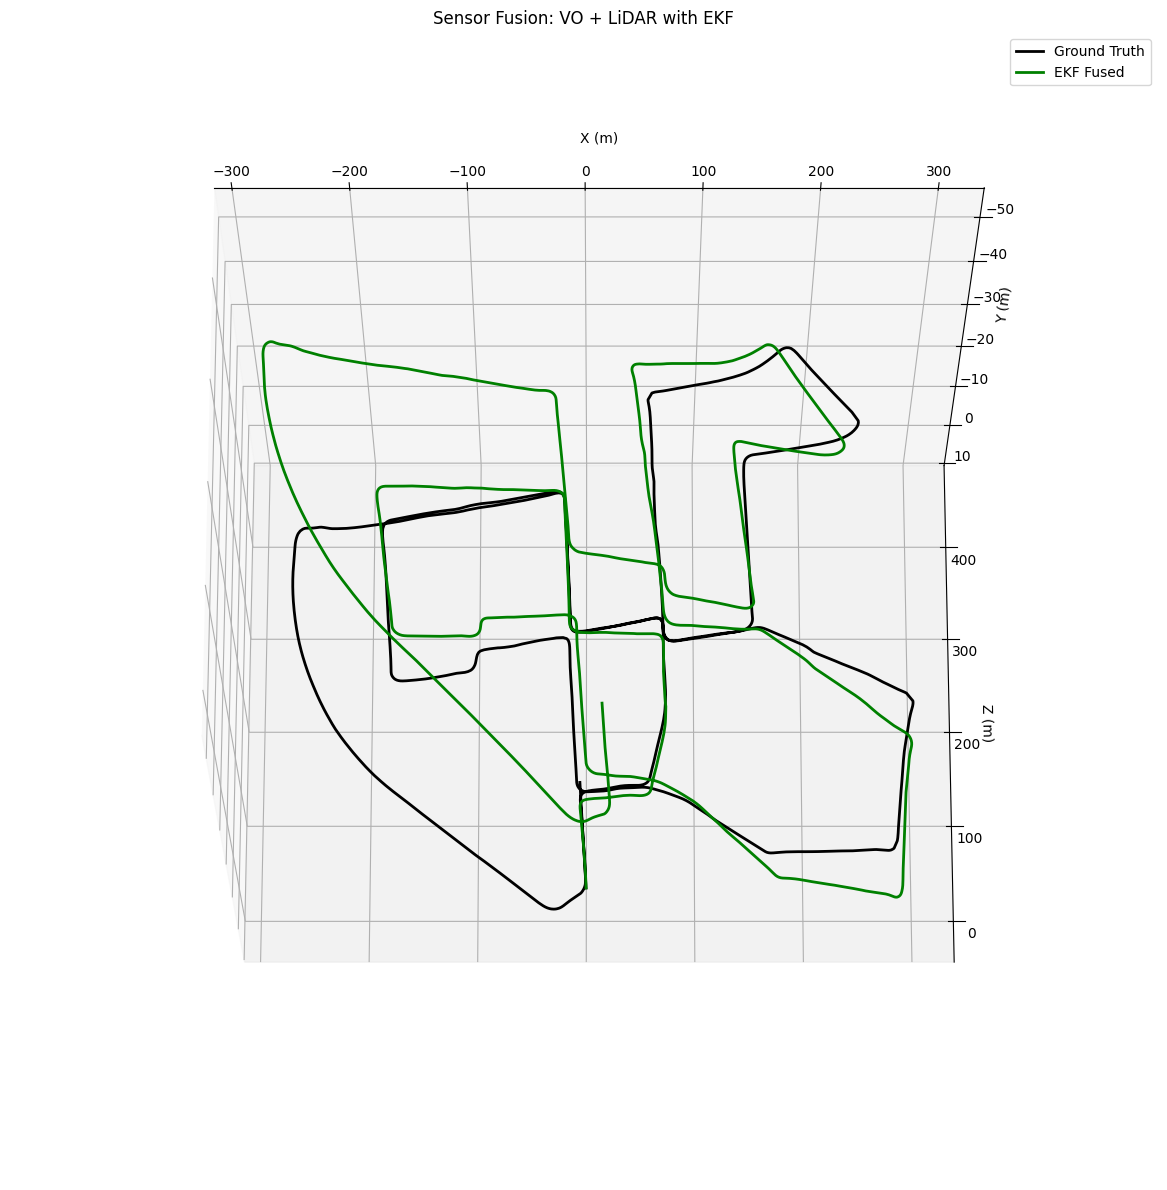

In [249]:
# Plot all trajectories comparison
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

num_frames_plot = trajectory_fused.shape[0]

# Ground truth
ax.plot(handler.gt[:num_frames_plot, 0, 3], 
        handler.gt[:num_frames_plot, 1, 3], 
        handler.gt[:num_frames_plot, 2, 3], 
        'k-', label='Ground Truth', linewidth=2)

# Visual Odometry
# ax.plot(trajectory_vo_new[:, 0, 3], 
#         trajectory_vo_new[:, 1, 3], 
#         trajectory_vo_new[:, 2, 3], 
#         'r-', label='Visual Odometry', linewidth=1.5, alpha=0.7)

# LiDAR Odometry
# ax.plot(trajectory_lidar_new[:, 0, 3], 
#         trajectory_lidar_new[:, 1, 3], 
#         trajectory_lidar_new[:, 2, 3], 
#         'b-', label='LiDAR ICP', linewidth=1.5, alpha=0.7)

# # Fused
ax.plot(trajectory_fused[:, 0, 3], 
        trajectory_fused[:, 1, 3], 
        trajectory_fused[:, 2, 3], 
        'g-', label='EKF Fused', linewidth=2)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
ax.view_init(elev=-20, azim=270)
plt.title('Sensor Fusion: VO + LiDAR with EKF')
plt.tight_layout()
plt.show()

In [246]:
# Calculate and compare errors
error_vo = calculate_error(handler.gt, trajectory_vo_new)
error_lidar = calculate_error(handler.gt, trajectory_lidar_new)
error_fused = calculate_error(handler.gt, trajectory_fused)

print('=' * 50)
print('ERROR COMPARISON')
print('=' * 50)
print(f"{'Method':<20} {'MAE (m)':<12} {'RMSE (m)':<12}")
print('-' * 50)
print(f"{'Visual Odometry':<20} {error_vo['mae']:<12.2f} {error_vo['rmse']:<12.2f}")
print(f"{'LiDAR ICP':<20} {error_lidar['mae']:<12.2f} {error_lidar['rmse']:<12.2f}")
print(f"{'EKF Fused':<20} {error_fused['mae']:<12.2f} {error_fused['rmse']:<12.2f}")
print('=' * 50)

# Highlight best
best_mae = min(error_vo['mae'], error_lidar['mae'], error_fused['mae'])
if error_fused['mae'] == best_mae:
    print('\n✓ Fusion achieved the lowest MAE!')
elif error_fused['mae'] < error_vo['mae'] and error_fused['mae'] < error_lidar['mae']:
    print('\n✓ Fusion improved over both individual methods!')

ERROR COMPARISON
Method               MAE (m)      RMSE (m)    
--------------------------------------------------
Visual Odometry      25.52        29.64       
LiDAR ICP            38.81        54.24       
EKF Fused            16.83        22.47       

✓ Fusion achieved the lowest MAE!


In [ ]:
# Plot error accumulation over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

num_frames = len(trajectory_fused)

# Calculate position error at each frame
error_vo_per_frame = np.sqrt(
    (handler.gt[:num_frames, 0, 3] - trajectory_vo_new[:, 0, 3])**2 +
    (handler.gt[:num_frames, 1, 3] - trajectory_vo_new[:, 1, 3])**2 +
    (handler.gt[:num_frames, 2, 3] - trajectory_vo_new[:, 2, 3])**2
)

error_lidar_per_frame = np.sqrt(
    (handler.gt[:num_frames, 0, 3] - trajectory_lidar_new[:, 0, 3])**2 +
    (handler.gt[:num_frames, 1, 3] - trajectory_lidar_new[:, 1, 3])**2 +
    (handler.gt[:num_frames, 2, 3] - trajectory_lidar_new[:, 2, 3])**2
)

error_fused_per_frame = np.sqrt(
    (handler.gt[:num_frames, 0, 3] - trajectory_fused[:, 0, 3])**2 +
    (handler.gt[:num_frames, 1, 3] - trajectory_fused[:, 1, 3])**2 +
    (handler.gt[:num_frames, 2, 3] - trajectory_fused[:, 2, 3])**2
)

# Error over time
axes[0].plot(error_vo_per_frame, 'r-', label='VO', alpha=0.7)
axes[0].plot(error_lidar_per_frame, 'b-', label='LiDAR', alpha=0.7)
axes[0].plot(error_fused_per_frame, 'g-', label='Fused', linewidth=2)
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Position Error (m)')
axes[0].legend()
axes[0].set_title('Error Accumulation Over Time')
axes[0].grid(True, alpha=0.3)

# Top-down view
axes[1].plot(handler.gt[:num_frames, 0, 3], handler.gt[:num_frames, 2, 3], 
             'k-', label='Ground Truth', linewidth=2)
axes[1].plot(trajectory_vo_new[:, 0, 3], trajectory_vo_new[:, 2, 3], 
             'r-', label='VO', alpha=0.7)
axes[1].plot(trajectory_lidar_new[:, 0, 3], trajectory_lidar_new[:, 2, 3], 
             'b-', label='LiDAR', alpha=0.7)
axes[1].plot(trajectory_fused[:, 0, 3], trajectory_fused[:, 2, 3], 
             'g-', label='Fused', linewidth=2)
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Z (m)')
axes[1].legend()
axes[1].set_title('Top-Down View (X-Z plane)')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Tuning the EKF

If the results aren't satisfactory, you can tune these parameters in the `EKF_Fusion` class:

**Process Noise (Q)** - How much you trust the motion model:
- Higher Q → Filter is more responsive to measurements
- Lower Q → Filter trusts constant velocity more (smoother but may lag)

**Measurement Noise (R_vo, R_lidar)** - How much you trust each sensor:
- Higher R → Less trust in that sensor
- Lower R → More trust in that sensor

```python
# Current settings:
self.R_vo = np.diag([2.0, 2.0, 5.0])    # VO: less trust in Z (depth)
self.R_lidar = np.diag([3.0, 3.0, 3.0]) # LiDAR: uniform uncertainty
```

Try adjusting these if one sensor is clearly better than the other in your results.

## Alternative: VO as Motion Model, LiDAR ICP as Observation

This is an alternative EKF formulation where:
- **Motion Model (Predict)**: Visual Odometry (using LiDAR depth) provides the predicted motion
- **Observation Model (Update)**: LiDAR ICP corrects the prediction

```
┌─────────────────────────────────────────────────────────────┐
│  PREDICT: Use VO relative pose (with LiDAR depth)           │
│           "VO says I moved by (R_vo, t_vo)"                 │
│           state_predicted = state + VO_motion               │
├─────────────────────────────────────────────────────────────┤
│  UPDATE: Correct with LiDAR ICP observation                 │
│          "LiDAR ICP says I'm actually at (x, y, z)"        │
│          Kalman gain weights prediction vs LiDAR            │
└─────────────────────────────────────────────────────────────┘
```

This treats VO as the "expected" motion and LiDAR ICP as the "correction".

In [250]:
class EKF_VO_Motion_Model:
    """
    Extended Kalman Filter where:
    - Motion Model: Visual Odometry with LiDAR depth (provides predicted motion)
    - Observation: LiDAR ICP (corrects the prediction)
    
    State: [x, y, z] (position only, rotation handled separately)
    """
    
    def __init__(self):
        # State vector: [x, y, z]
        self.state = np.zeros(3)
        
        # State covariance matrix
        self.P = np.eye(3) * 1.0
        
        # Process noise (uncertainty in VO motion model)
        # Higher = less trust in VO, more responsive to LiDAR
        self.Q = np.diag([1.0, 1.0, 2.0])  # VO is less accurate in Z
        
        # Observation matrix (we directly observe position)
        self.H = np.eye(3)
        
        # Measurement noise (uncertainty in LiDAR ICP observation)
        # Lower = more trust in LiDAR
        self.R = np.diag([0.5, 0.5, 0.5])  # LiDAR ICP
    
    def predict(self, vo_delta_position):
        """
        Prediction step using VO motion.
        
        Args:
            vo_delta_position: [dx, dy, dz] motion from VO
        """
        # State transition: add VO motion to current state
        self.state = self.state + np.array(vo_delta_position)
        
        # Covariance grows by process noise
        self.P = self.P + self.Q
        
        return self.state.copy()
    
    def update(self, lidar_position):
        """
        Update step using LiDAR ICP observation.
        
        Args:
            lidar_position: [x, y, z] absolute position from LiDAR ICP odometry
        """
        z = np.array(lidar_position)
        
        # Innovation (measurement residual)
        y = z - self.H @ self.state
        
        # Innovation covariance
        S = self.H @ self.P @ self.H.T + self.R
        
        # Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # Update state
        self.state = self.state + K @ y
        
        # Update covariance
        I = np.eye(3)
        self.P = (I - K @ self.H) @ self.P
        
        return self.state.copy()
    
    def get_position(self):
        return self.state.copy()

In [251]:
def fused_odometry_vo_motion_model(handler, vo_params=None, lidar_params=None, subset=None):
    """
    Sensor fusion where VO (with LiDAR depth) is the motion model 
    and LiDAR ICP is the observation.
    
    Args:
        handler: Dataset handler
        vo_params: Dict of VO parameters
        lidar_params: Dict of LiDAR ICP parameters
        subset: Number of frames to process
    
    Returns:
        trajectory_fused: Fused trajectory
        trajectory_vo: VO-only trajectory (with LiDAR depth)
        trajectory_lidar: LiDAR ICP-only trajectory
    """
    if vo_params is None:
        vo_params = {'detector': 'sift', 'matching': 'BF', 
                     'filter_match_distance': 0.5, 'stereo_matcher': 'sgbm'}
    if lidar_params is None:
        lidar_params = {'voxel_size': 0.3, 'max_correspondence': 1.0}
    
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    
    print(f'Running Fused Odometry (VO Motion Model) on {num_frames} frames')
    print(f'Motion Model: Visual Odometry with LiDAR depth (lidar_only mode)')
    print(f'Observation: LiDAR ICP')
    
    # Initialize trajectories
    trajectory_fused = np.zeros((num_frames, 3, 4))
    trajectory_vo = np.zeros((num_frames, 3, 4))
    trajectory_lidar = np.zeros((num_frames, 3, 4))
    
    # Initialize poses
    T_vo = np.eye(4)
    T_lidar = np.eye(4)
    T_fused = np.eye(4)
    
    trajectory_fused[0] = T_fused[:3, :]
    trajectory_vo[0] = T_vo[:3, :]
    trajectory_lidar[0] = T_lidar[:3, :]
    
    # Previous position for computing VO delta
    prev_vo_position = np.zeros(3)
    
    # Initialize EKF with VO as motion model
    ekf = EKF_VO_Motion_Model()
    
    # Get camera intrinsics
    k_left, _, _ = decompose_proj_mat(handler.P0)
    
    imheight = handler.img_height
    imwidth = handler.img_width
    
    # Reset generators
    handler.reset_frames()
    
    # Get first frames
    image_left = next(handler.img_L)
    image_right = next(handler.img_R)
    pc_prev = next(handler.pcs)
    pcd_prev = preprocess_point_cloud(pc_prev, lidar_params['voxel_size'], Tr=handler.Tr)
    
    last_T_icp = np.eye(4)
    
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
        # Get next frames
        image_left_next = next(handler.img_L)
        image_right_next = next(handler.img_R)
        pc_curr = next(handler.pcs)
        
        # ============ VISUAL ODOMETRY WITH LIDAR DEPTH (MOTION MODEL) ============
        # Get LiDAR depth map for VO
        lidar_depth_map = pc_to_img(pc_prev, imheight=imheight, imwidth=imwidth,
                                    Tr=handler.Tr, P0=handler.P0)
        
        # Get stereo depth as fallback
        depth, f_mask = stereo_to_depth(image_left, image_right,
                                        handler.P0, handler.P1,
                                        matcher=vo_params['stereo_matcher'])
        
        # Feature matching
        kp0, kp1, matches = generate_matches(image_left, image_left_next,
                                             detector=vo_params['detector'],
                                             matching=vo_params['matching'],
                                             mask=f_mask,
                                             dist_threshold=vo_params['filter_match_distance'])
        
        # Estimate motion using LiDAR depth only (lidar_only=True)
        rmat_vo, tvec_vo, _, _ = estimate_motion(
            matches, kp0, kp1, k_left,
            depth1=depth,              # Fallback depth
            lidar_depth=lidar_depth_map,
            lidar_only=True            # Use only keypoints with LiDAR depth
        )
        
        # Build and accumulate VO pose
        T_delta_vo = np.eye(4)
        T_delta_vo[:3, :3] = rmat_vo
        T_delta_vo[:3, 3] = tvec_vo.flatten()
        T_vo = T_vo @ np.linalg.inv(T_delta_vo)
        trajectory_vo[i + 1] = T_vo[:3, :]
        
        # Compute VO delta motion (for EKF prediction)
        current_vo_position = T_vo[:3, 3]
        vo_delta = current_vo_position - prev_vo_position
        prev_vo_position = current_vo_position.copy()
        
        # ============ LIDAR ICP ODOMETRY (OBSERVATION) ============
        pcd_curr = preprocess_point_cloud(pc_curr, lidar_params['voxel_size'], Tr=handler.Tr)
        
        T_icp, fitness, rmse = run_icp(pcd_curr, pcd_prev,
                                       lidar_params['max_correspondence'],
                                       init_transform=last_T_icp)
        
        if fitness > 0.3:
            last_T_icp = T_icp
        
        T_lidar = T_lidar @ T_icp
        trajectory_lidar[i + 1] = T_lidar[:3, :]
        
        lidar_position = T_lidar[:3, 3]
        
        # ============ EKF: VO PREDICTS, LIDAR CORRECTS ============
        # Predict using VO motion (motion model)
        predicted_position = ekf.predict(vo_delta)
        
        # Update with LiDAR ICP observation
        fused_position = ekf.update(lidar_position)
        
        # Build fused transformation
        T_fused[:3, :3] = T_vo[:3, :3]  # Use VO rotation
        T_fused[:3, 3] = fused_position
        trajectory_fused[i + 1] = T_fused[:3, :]
        
        # Update for next iteration
        image_left = image_left_next
        image_right = image_right_next
        pc_prev = pc_curr
        pcd_prev = pcd_curr
        
        end = datetime.datetime.now()
        
        if (i + 1) % 100 == 0 or i == 0:
            print(f'Frame {i + 1}/{num_frames - 1}, '
                  f'ICP fitness: {fitness:.3f}, Time: {end - start}')
    
    print('\nFused Odometry (VO Motion Model) complete!')
    return trajectory_fused, trajectory_vo, trajectory_lidar

### Run Alternative Fusion (VO as Motion Model, LiDAR ICP as Observation)

In [252]:
# Run fusion with VO (LiDAR depth) as motion model
start = datetime.datetime.now()

trajectory_fused_alt, trajectory_vo_alt, trajectory_lidar_alt = fused_odometry_vo_motion_model(
    handler,
    vo_params={'detector': 'sift', 'matching': 'BF',
               'filter_match_distance': 0.5, 'stereo_matcher': 'sgbm'},
    lidar_params={'voxel_size': 0.3, 'max_correspondence': 1.0},
    subset=None  # Set to 500 for quick test
)

end = datetime.datetime.now()
print(f'\nTotal time: {end - start}')

Running Fused Odometry (VO Motion Model) on 4541 frames
Motion Model: Visual Odometry with LiDAR depth (lidar_only mode)
Observation: LiDAR ICP
Frame 1/4540, ICP fitness: 0.969, Time: 0:00:00.464157
Frame 100/4540, ICP fitness: 0.997, Time: 0:00:00.348545
Frame 200/4540, ICP fitness: 0.979, Time: 0:00:00.359485
Frame 300/4540, ICP fitness: 0.980, Time: 0:00:00.382320
Frame 400/4540, ICP fitness: 0.957, Time: 0:00:00.337024
Frame 500/4540, ICP fitness: 0.964, Time: 0:00:00.368043
Frame 600/4540, ICP fitness: 0.996, Time: 0:00:00.378947
Frame 700/4540, ICP fitness: 0.994, Time: 0:00:00.346463
Frame 800/4540, ICP fitness: 0.950, Time: 0:00:00.444535
Frame 900/4540, ICP fitness: 0.959, Time: 0:00:00.510816
Frame 1000/4540, ICP fitness: 0.986, Time: 0:00:00.395540
Frame 1100/4540, ICP fitness: 0.970, Time: 0:00:00.378353
Frame 1200/4540, ICP fitness: 0.961, Time: 0:00:00.527619
Frame 1300/4540, ICP fitness: 0.985, Time: 0:00:00.359919
Frame 1400/4540, ICP fitness: 0.987, Time: 0:00:00.35516

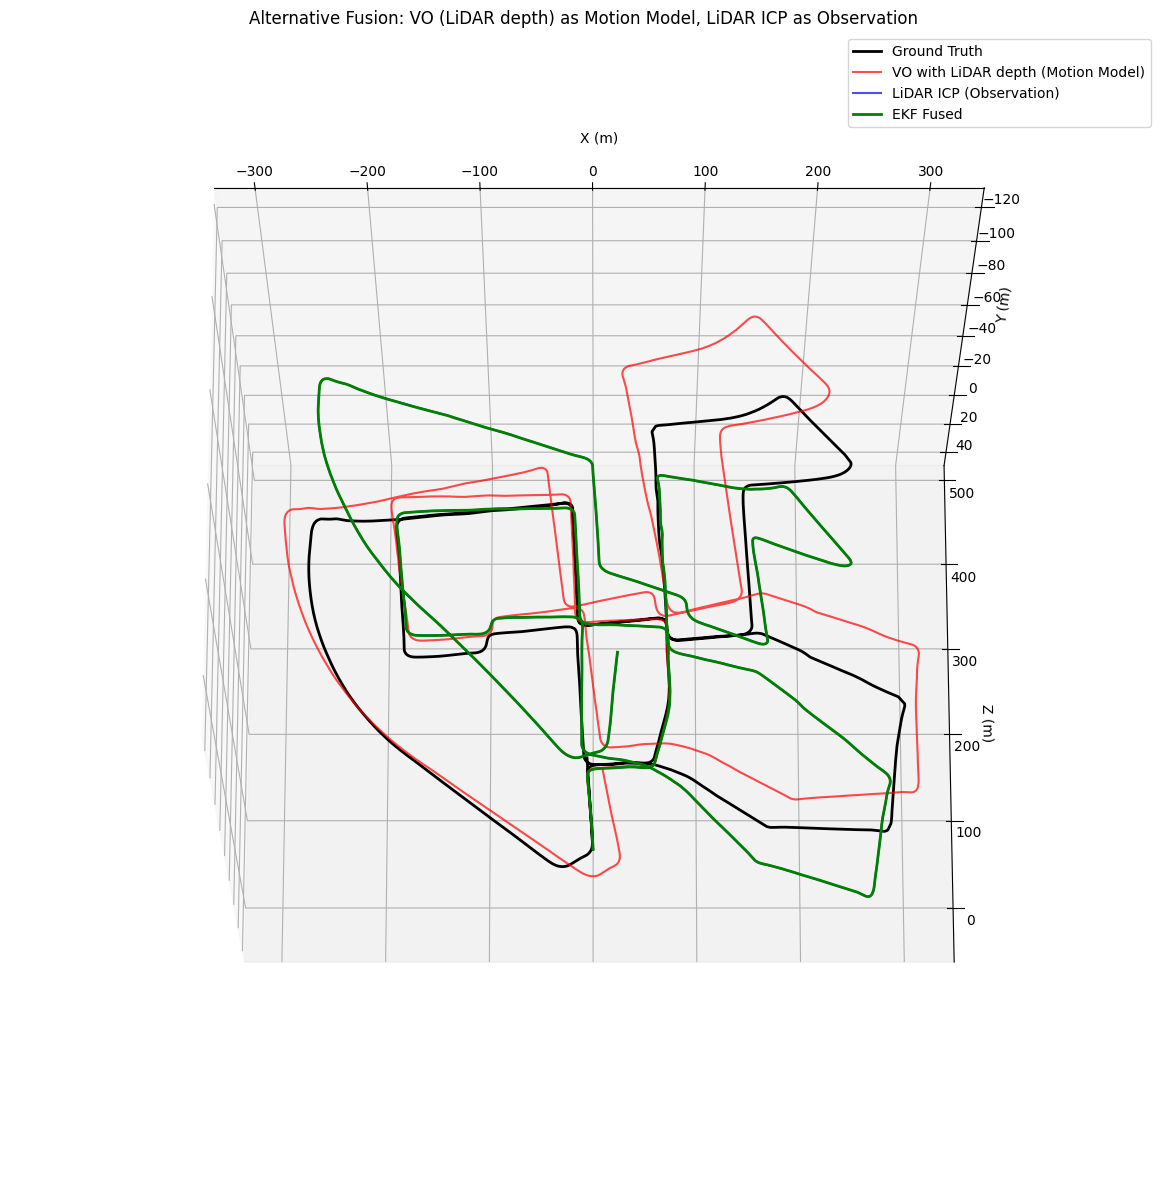

In [254]:
# Plot alternative fusion results
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

num_frames_plot = trajectory_fused_alt.shape[0]

ax.plot(handler.gt[:num_frames_plot, 0, 3],
        handler.gt[:num_frames_plot, 1, 3],
        handler.gt[:num_frames_plot, 2, 3],
        'k-', label='Ground Truth', linewidth=2)

ax.plot(trajectory_vo_alt[:, 0, 3],
        trajectory_vo_alt[:, 1, 3],
        trajectory_vo_alt[:, 2, 3],
        'r-', label='VO with LiDAR depth (Motion Model)', linewidth=1.5, alpha=0.7)

ax.plot(trajectory_lidar_alt[:, 0, 3],
        trajectory_lidar_alt[:, 1, 3],
        trajectory_lidar_alt[:, 2, 3],
        'b-', label='LiDAR ICP (Observation)', linewidth=1.5, alpha=0.7)

ax.plot(trajectory_fused_alt[:, 0, 3],
        trajectory_fused_alt[:, 1, 3],
        trajectory_fused_alt[:, 2, 3],
        'g-', label='EKF Fused', linewidth=2)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.legend()
ax.view_init(elev=-20, azim=270)
plt.title('Alternative Fusion: VO (LiDAR depth) as Motion Model, LiDAR ICP as Observation')
plt.tight_layout()
plt.show()

In [253]:
# Compare errors: Alternative fusion
error_vo_alt = calculate_error(handler.gt, trajectory_vo_alt)
error_lidar_alt = calculate_error(handler.gt, trajectory_lidar_alt)
error_fused_alt = calculate_error(handler.gt, trajectory_fused_alt)

print('=' * 60)
print('ERROR COMPARISON: VO Motion Model + LiDAR ICP Observation')
print('=' * 60)
print(f"{'Method':<35} {'MAE (m)':<12} {'RMSE (m)':<12}")
print('-' * 60)
print(f"{'VO with LiDAR depth (Motion Model)':<35} {error_vo_alt['mae']:<12.2f} {error_vo_alt['rmse']:<12.2f}")
print(f"{'LiDAR ICP (Observation)':<35} {error_lidar_alt['mae']:<12.2f} {error_lidar_alt['rmse']:<12.2f}")
print(f"{'EKF Fused':<35} {error_fused_alt['mae']:<12.2f} {error_fused_alt['rmse']:<12.2f}")
print('=' * 60)

ERROR COMPARISON: VO Motion Model + LiDAR ICP Observation
Method                              MAE (m)      RMSE (m)    
------------------------------------------------------------
VO with LiDAR depth (Motion Model)  25.52        29.64       
LiDAR ICP (Observation)             38.81        54.24       
EKF Fused                           38.80        54.23       


In [ ]:
# Compare BOTH fusion approaches side by side
print('=' * 70)
print('COMPARISON OF BOTH FUSION APPROACHES')
print('=' * 70)
print(f"{'Approach':<45} {'MAE (m)':<12} {'RMSE (m)':<12}")
print('-' * 70)

# Option A: Symmetric fusion (constant velocity + both as observations)
if 'error_fused' in dir():
    print(f"{'Option A: CV model + both as observations':<45} {error_fused['mae']:<12.2f} {error_fused['rmse']:<12.2f}")

# Option B: VO motion model + LiDAR observation
print(f"{'Option B: VO motion model + LiDAR obs':<45} {error_fused_alt['mae']:<12.2f} {error_fused_alt['rmse']:<12.2f}")

print('=' * 70)
print('\nOption A: Constant velocity prediction, VO & LiDAR both as observations')
print('Option B: VO provides motion prediction, LiDAR ICP corrects it')